In [1]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
import sys
import math
from PIL import Image
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
prefix = './'    # This is the prefix for where all of the data files come from

# Clustering Images

In this example, you will classify and cluster a set of noisy images to reconstruct the original ones.

Read in matrix of size  (16384, 1000)
Image size is  128


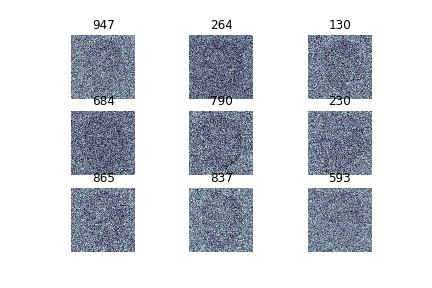

In [3]:
A = np.load(prefix + 'homework.npy')
print("Read in matrix of size ", A.shape)
(y, x) = A.shape
imdim = int(math.sqrt(y))
print("Image size is ", imdim)

indices = np.random.randint(0, x, 9)   # pick 9 random images from the ensemble
for i in range(9):
    plt.subplot(3,3,i+1)               # Combine multiple plots into one big one (3x3)
    X = A[:, indices[i]].reshape(imdim, imdim)
    plt.imshow(X, cmap="bone")
    plt.axis('off')
    plt.title(indices[i])

plt.show()

In order to calculate the PCA, we must first subtract off the average image...  Then we can feed this to the Singular Value Decomposition function to characterize the data matrix.  This may take a few moments.  Note that here we're passing False to the `svd` function.  This is because we don't need the _full_ SVD result to cluster the data.  We're really only intersted in the first few terms since they will be the most significant.  By _not_ computing the full SVD, we can save a lot of storage and time.

In [4]:
m = np.mean(A, axis=1)    # Compute the average column (image)
for i in range(x):        # Subtract the average column from every column in the ensemble
    A[:, i] -= m

print('Computing SVD...')
U, s, V = np.linalg.svd(A, False)
print(U.shape)
print('Done!')
V = np.transpose(V)   # The SVD returns the transpose of V, so transpose it back...

Computing SVD...
(16384, 1000)
Done!


Remember, the first thing you want to do is to look at the singular values.  These give you the relative importance of each of the principal components (i.e. classification dimensions).

**Show a plot of the singular values as a line graph.  Be sure to use markers/glyphs so we can see where the singular values are on the line. (10 points)**

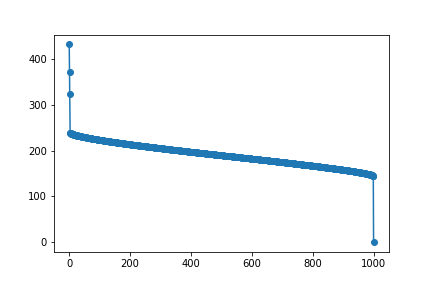

In [5]:
plt.plot(s,'o-')
plt.show()

**How many singular values do you think are significant?  Set the variable `nclusters` below to that number... (5 points)**

In [6]:
nclusters = 4

**What is the percent contribution of the first principal component?  What about the 2nd?  (5 points)**

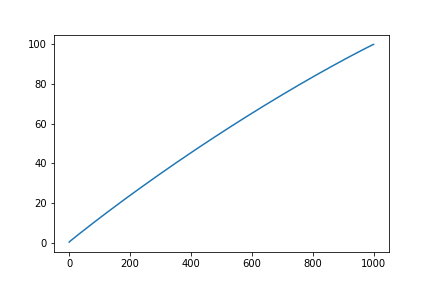

In [7]:
percent_contribution = np.cumsum(s) / np.sum(s) * 100.0
plt.plot(percent_contribution)
plt.show()

#The 2nd is ommitted to reduce dimension. If we were to project the positions of the points onto the 1st PC, 
#we would have a reduced representation of the data.
#About 20% for the first PCA

Now, let's take a look at the histogram if we classify our images based solely on the first PC (i.e. the first RSV).  The number of bins used in a histogram can have a big impact on how the data distribution looks.  Try adjusting the slider and see if this changes how many clusters you think there might be...

In [8]:
def histogramFirstRSV(nbins):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(V[:,0], bins=nbins, histtype='step')
    plt.show()
    
interact(histogramFirstRSV, nbins=widgets.IntSlider(min=10, max=100, step=1, value=10, continuous_update = False));

interactive(children=(IntSlider(value=10, continuous_update=False, description='nbins', min=10), Output()), _d…

**How many clusters do you see?  Enter it in the cell below... (5 points)**

In [9]:
nclusters = 3

Now, we're going to try a very simple clustering method: sorting.  If we sort the first RSV, images that are similar will be next to each other.

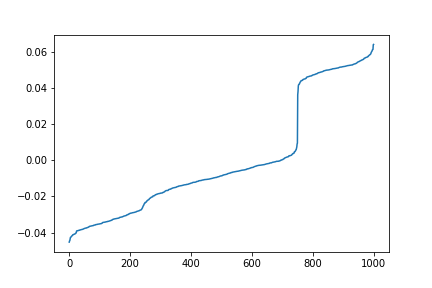

In [10]:
indices = np.argsort(V[:,0])
plt.plot(V[indices,0])
plt.show()

Do you still think you see the same number of clusters?  Let's use this clustering to pull out similar images and average them together.  _We are going to assume here that each cluster is the same size..._

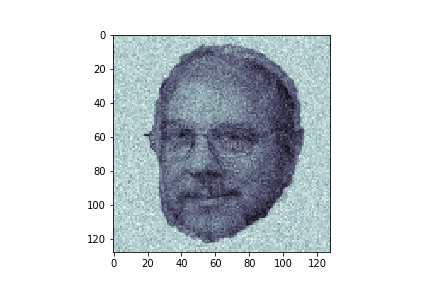

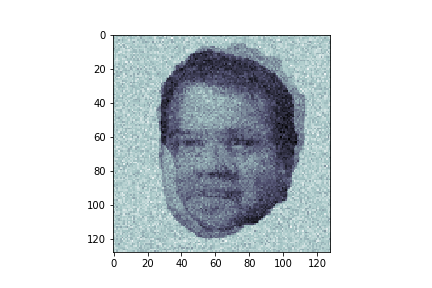

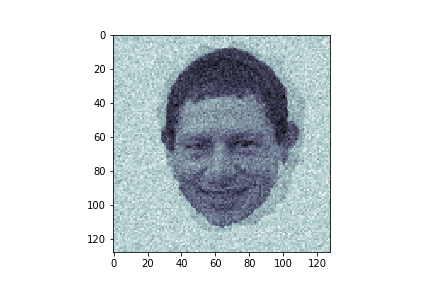

In [11]:
clustsize = x / nclusters

for j in range(nclusters):
    plt.figure(j+1)
    lower = int(j * clustsize)
    upper = int((j+1) * clustsize)
    image = np.mean(A[:, indices[lower:upper]], axis=1) + m
    image = image.reshape(imdim, imdim)
    plt.imshow(image, cmap='bone')
    
plt.show()

Does the result look correct to you?  Can we get by with just classifying using the first principal component?  Let's look a little further into the phase space and see what's going on in our classification.

**Show a scatter plot comparing the 1st and 2nd principal components, and another comparing the 2nd and 3rd principal components. Make the figure a single figure that has the two scatter plots as subplots arranged as two plots on one row.  Be sure to label your axes.  You may want to make the much wider than it is tall. (15 points)**

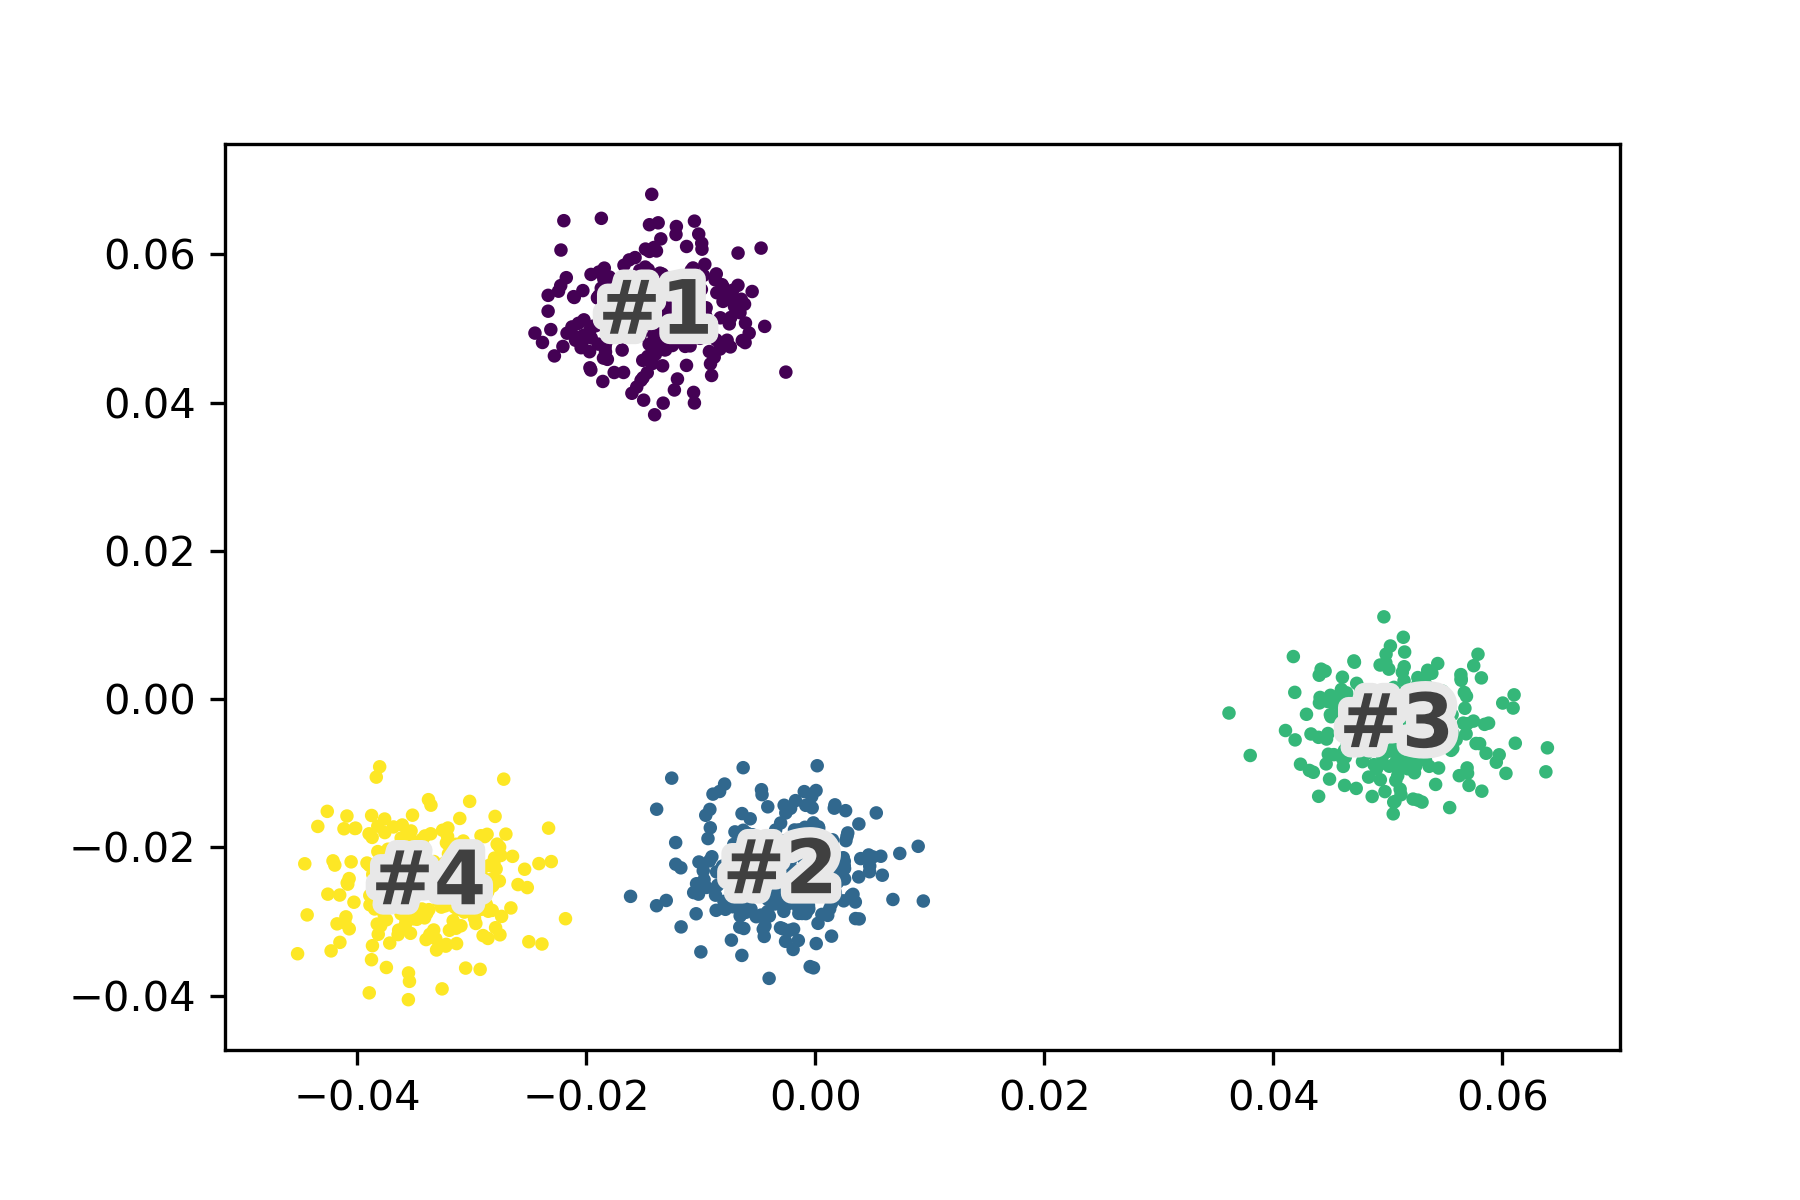

In [12]:
clusters = KMeans(n_clusters=4,
                  random_state=0).fit(V[:,0:4])
classification = clusters.labels_
centroids = clusters.cluster_centers_

plt.figure(dpi=300)

plt.scatter(V[:,0],V[:,1], c=classification, s=5)

text_properties = {
    'family': 'sans-serif',
    'color':  '#404040',    # Use a dark-gray here (RGB in hex)
    'weight': 'extra bold',
    'size': 18
    }

for i in range(len(centroids)):
    text_object = plt.text(centroids[i, 0],
                           centroids[i, 1],
                           '#{}'.format(i+1),
                           va='center',
                           ha='center',
                           fontdict=text_properties)
    
    text_object.set_path_effects(
        [PathEffects.withStroke(linewidth=5,
                                foreground='#E8E8E8')
        ])
    
plt.show()    

**Has your guess for the number of clusters changed?  Adjust the number of clusters that are in the data below... (10 points)**

In [13]:
nclusters = 4

**At what point (principal component) does the PCA just show noise?  Set the variable 'noise_index' to the index of the first principal component that looks like noise.  Remember, python is 0-based indexing, so the 5th component would have an index of 4.  Also remember that noise will appear like a gaussian in the PCA.  You may want to show your work... (15 points)**

In [14]:
# setting noise index=2 will have the PCA look like noise
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])

def phase(i):
    plt.plot(V[:,i], V[:, i+1], '.')
    plt.xlabel(ordinal(i) + ' PC')
    plt.ylabel(ordinal(i+1) + ' PC')
    plt.show()

(pca_m, pca_n) = V.shape
interact(phase, i=widgets.BoundedIntText(value=0, min=0, max=pca_n-2, step=1, description='noise index', continuous_update=False));



interactive(children=(BoundedIntText(value=0, description='noise index', max=998), Output()), _dom_classes=('w…

**Let's re-cluster the data using K-Means.  Show a scatter plot of the first two principal components, colored by cluster ID and add the cluster ID as a text annotation.  Remember what we talked about in class about adding text to plots: it must be legible! (15 points)**

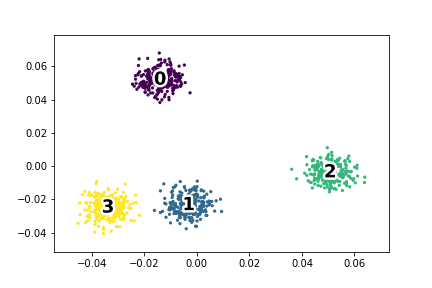

In [15]:
clusters = KMeans(n_clusters=nclusters, random_state=0).fit(V[:,0:2])
classification = clusters.labels_
fig, ax = plt.subplots()
ax.scatter(V[:,0],V[:,1],c=classification, s=5)

centroids = clusters.cluster_centers_
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'extra bold',
        'size': 18,
        }
for i in range(nclusters):
    txt = plt.text(centroids[i,0], centroids[i,1], str(i), va='center', ha='center',fontdict=font)
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    
plt.show()

**Now, using the clusters derived above, reconstruct the original images used to make this dataset. (20 points)**

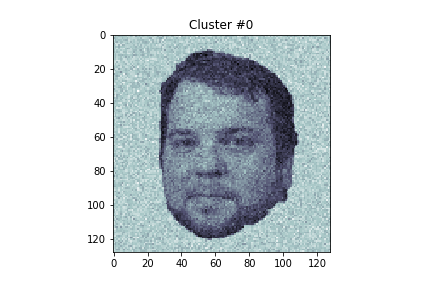

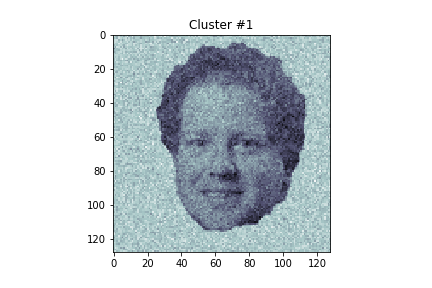

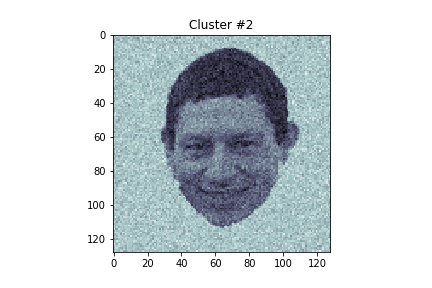

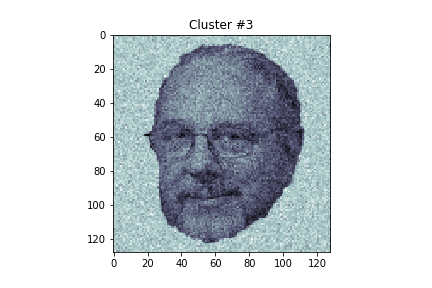

In [16]:
for j in range(nclusters):
    plt.figure(j+1)
    #indices = np.argwhere(classification == j).reshape(clustsize)
    indices = np.argwhere(classification == j).reshape(-1)
    image = np.mean(A[:, indices], axis = 1) + m
    image = image.reshape(imdim, imdim)
    plt.title('Cluster #%d' % j)
    plt.imshow(image, cmap='bone')
    
plt.show()